(lake_model)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# 就业和失业的湖泊模型

```{index} single: Lake Model
```

```{contents} Contents
:depth: 2
```

除了Anaconda中包含的内容外，本讲座还需要以下库：

In [1]:
!pip install quantecon

## 概述

本讲座描述所谓的*湖泊模型*。

湖泊模型是建模失业的基本工具。

它允许我们分析：

* 失业和就业之间的流动
* 这些流动如何影响稳态就业和失业率

它是解释劳工部门关于总就业创造和破坏以及净就业创造月度报告的良好模型。

模型中的"湖泊"是就业和失业的劳动力池。

"湖泊"之间的流动是由以下因素造成的：

* 解雇和雇佣
* 劳动力的进入和退出

在本讲座的第一部分，失业和就业之间的转换参数是外生的。

之后，我们将使用{doc}`McCall搜索模型 <mccall_model>`内生地确定一些转换率。

我们还将使用一些巧妙的概念，如遍历性，它提供了*横截面*和*长期时间序列*分布之间的基本联系。

这些概念将帮助我们建立一个事前同质劳动者的均衡模型，他们的不同运气产生了事后经验的差异。

让我们从一些导入开始：

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

plt.rcParams["figure.figsize"] = (11, 5)  #设置默认图形大小
import numpy as np
from quantecon import MarkovChain
from scipy.stats import norm
from scipy.optimize import brentq
from quantecon.distributions import BetaBinomial
from numba import jit

### 先决条件

在继续之前，我们建议您阅读
{doc}`有限马尔可夫链讲座 <finite_markov>`。

您还需要一些基本的{doc}`线性代数 <linear_algebra>`和概率论知识。

## 模型

经济中有大量事前相同的劳动者。

这些劳动者永久存在，在失业和就业之间度过一生。

他们在就业和失业之间的转换率由以下参数决定：

* $\lambda$，当前失业劳动者的工作找到率
* $\alpha$，当前就业劳动者的解雇率
* $b$，劳动力进入率
* $d$，劳动力退出率

劳动力的增长率显然等于 $g=b-d$。

### 总量变量

我们想要推导以下总量的动态：

* $E_t$，t时刻就业劳动者总数
* $U_t$，t时刻失业劳动者总数
* $N_t$，t时刻劳动力总数

我们还想知道以下对象的值：

* 就业率 $e_t := E_t/N_t$
* 失业率 $u_t := U_t/N_t$

（这里和下面，大写字母代表总量，小写字母代表比率）

### 存量变量的运动规律

我们首先构建总量变量 $E_t,U_t, N_t$ 的运动规律。

对于t时刻就业的 $E_t$ 劳动者群体：

* $(1-d)E_t$ 将留在劳动力中
* 其中，$(1-\alpha)(1-d)E_t$ 将保持就业

对于t时刻失业的 $U_t$ 劳动者群体：

* $(1-d)U_t$ 将留在劳动力中
* 其中，$(1-d) \lambda U_t$ 将找到工作

因此，t+1时刻的就业劳动者数量将是：

$$
E_{t+1} = (1-d)(1-\alpha)E_t + (1-d)\lambda U_t
$$

类似的分析表明：

$$
U_{t+1} = (1-d)\alpha E_t + (1-d)(1-\lambda)U_t + b (E_t+U_t)
$$

值 $b(E_t+U_t)$ 是作为失业者进入劳动力的新劳动者数量。

劳动者总量 $N_t=E_t+U_t$ 的演变如下：

$$
N_{t+1} = (1+b-d)N_t = (1+g)N_t
$$

令 $X_t := \left(\begin{matrix}U_t\\E_t\end{matrix}\right)$，X的运动规律为：

$$
X_{t+1} = A X_t
\quad \text{其中} \quad
A :=
\begin{pmatrix}
    (1-d)(1-\lambda) + b & (1-d)\alpha + b  \\
    (1-d)\lambda & (1-d)(1-\alpha)
\end{pmatrix}
$$

这个规律告诉我们总就业和失业如何随时间演变。

### 比率的运动规律

现在让我们推导比率的运动规律。

为此，我们可以将 $X_{t+1} = A X_t$ 的两边都除以 $N_{t+1}$ 得到：

$$
\begin{pmatrix}
    U_{t+1}/N_{t+1} \\
    E_{t+1}/N_{t+1}
\end{pmatrix} =
\frac1{1+g} A
\begin{pmatrix}
    U_{t}/N_{t}
    \\
    E_{t}/N_{t}
\end{pmatrix}
$$

令：

$$
x_t :=
\left(\begin{matrix}
    u_t\\ e_t
\end{matrix}\right) =
\left(\begin{matrix}
    U_t/N_t\\ E_t/N_t
\end{matrix}\right)
$$

我们也可以将其写为：

$$
x_{t+1} = \hat A x_t
\quad \text{其中} \quad
\hat A := \frac{1}{1 + g} A
$$

您可以验证 $e_t + u_t = 1$ 意味着 $e_{t+1}+u_{t+1} = 1$。

这可以从 $\hat A$ 的列和为1这一事实得出。

## 实现

让我们编写这些方程。

为此，我们将使用一个名为 `LakeModel` 的类。

这个类将：

1. 存储原始参数 $\alpha, \lambda, b, d$
1. 计算并存储隐含对象 $g, A, \hat A$
1. 提供模拟存量和比率动态的方法
2. 提供一个使用{ref}`我们之前介绍的用于计算马尔可夫链平稳分布的技术 <dynamics_workers>`来计算就业和失业率稳态向量 $\bar x$ 的方法

请注意，如果您只改变原始参数，隐含对象 $g, A, \hat A$ 不会改变。

例如，如果您想更新原始参数如 $\alpha = 0.03$，
您需要通过 `lm = LakeModel(α=0.03)` 创建一个新实例。

在练习中，我们将展示如何使用getter和setter方法来避免这个问题。

In [3]:
class LakeModel:
    """
    求解湖泊模型并计算失业存量和比率的动态。

    参数:
    ------------
    λ : 标量
        当前失业劳动者的工作找到率
    α : 标量
        当前就业劳动者的解雇率
    b : 标量
        劳动力进入率
    d : 标量
        劳动力退出率

    """
    def __init__(self, λ=0.283, α=0.013, b=0.0124, d=0.00822):
        self.λ, self.α, self.b, self.d = λ, α, b, d

        λ, α, b, d = self.λ, self.α, self.b, self.d
        self.g = b - d
        self.A = np.array([[(1-d) * (1-λ) + b,      (1 - d) * α + b],
                           [        (1-d) * λ,      (1 - d) * (1 - α)]])

        self.A_hat = self.A / (1 + self.g)


    def rate_steady_state(self, tol=1e-6):
        """
        找到系统 :math:`x_{t+1} = \hat A x_{t}` 的稳态

        返回
        --------
        xbar : 就业和失业率的稳态向量
        """
        x = np.array([self.A_hat[0, 1], self.A_hat[1, 0]])
        x /= x.sum()
        return x

    def simulate_stock_path(self, X0, T):
        """
        模拟就业和失业存量的序列

        参数
        ------------
        X0 : 数组
            包含初始值 (E0, U0)
        T : 整数
            模拟的时期数

        返回
        ---------
        X : 迭代器
            包含就业和失业存量的序列
        """

        X = np.atleast_1d(X0)  # 转换为数组以防万一
        for t in range(T):
            yield X
            X = self.A @ X

    def simulate_rate_path(self, x0, T):
        """
        模拟就业和失业率的序列

        参数
        ------------
        x0 : 数组
            包含初始值 (e0,u0)
        T : 整数
            模拟的时期数

        返回
        ---------
        x : 迭代器
            包含就业和失业率的序列

        """
        x = np.atleast_1d(x0)  # 转换为数组以防万一
        for t in range(T):
            yield x
            x = self.A_hat @ x

<>:29: SyntaxWarning: invalid escape sequence '\h'
<>:29: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_6682/3790059362.py:29: SyntaxWarning: invalid escape sequence '\h'
  """


如前所述，如果我们创建一个实例并通过 `lm = LakeModel(α=0.03)` 更新它，
隐含对象如 $A$ 也会改变。

In [4]:
lm = LakeModel()
lm.α

0.013

In [5]:
lm.A

array([[0.72350626, 0.02529314],
       [0.28067374, 0.97888686]])

In [6]:
lm = LakeModel(α = 0.03)
lm.A

array([[0.72350626, 0.0421534 ],
       [0.28067374, 0.9620266 ]])

### 总量动态

让我们在默认参数下（见上文）从 $X_0 = (12, 138)$ 开始运行模拟

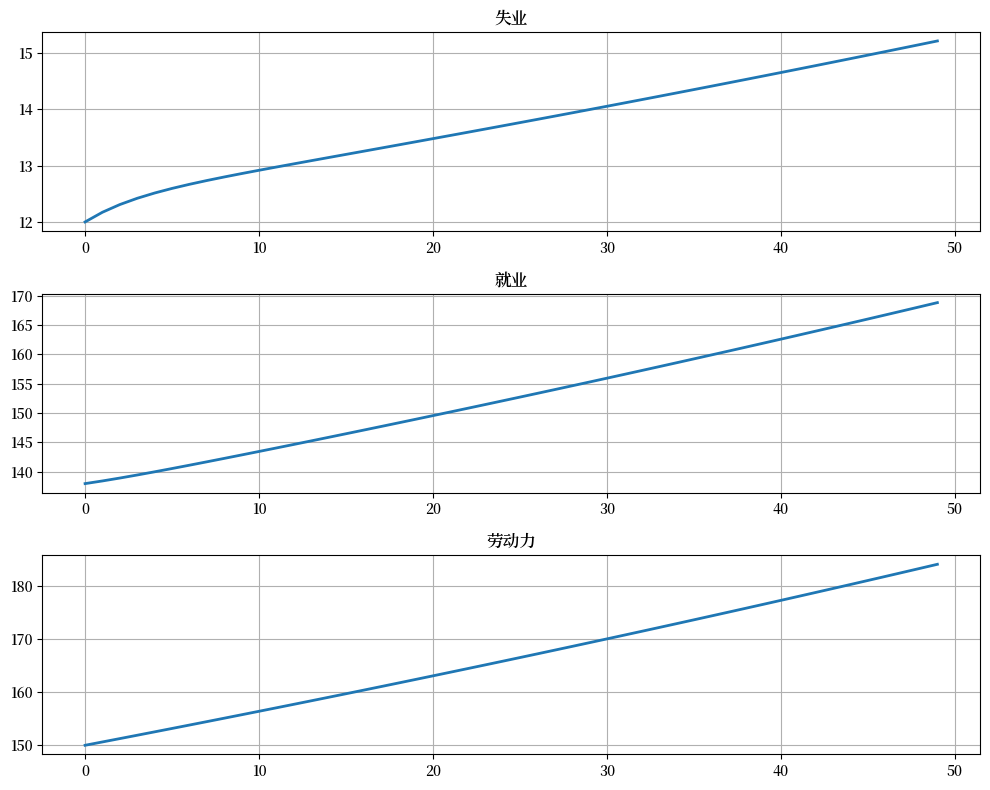

In [7]:
lm = LakeModel()
N_0 = 150      # 人口
e_0 = 0.92     # 初始就业率
u_0 = 1 - e_0  # 初始失业率
T = 50         # 模拟长度

U_0 = u_0 * N_0
E_0 = e_0 * N_0

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
X_0 = (U_0, E_0)
X_path = np.vstack(tuple(lm.simulate_stock_path(X_0, T)))

axes[0].plot(X_path[:, 0], lw=2)
axes[0].set_title('失业')

axes[1].plot(X_path[:, 1], lw=2)
axes[1].set_title('就业')

axes[2].plot(X_path.sum(1), lw=2)
axes[2].set_title('劳动力')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

总量 $E_t$ 和 $U_t$ 不会收敛，因为它们的和 $E_t + U_t$ 以速率 $g$ 增长。

另一方面，就业和失业率向量 $x_t$ 可以在稳态 $\bar x$ 中，如果
存在 $\bar x$ 使得：

* $\bar x = \hat A \bar x$
* 分量满足 $\bar e + \bar u = 1$

这个方程告诉我们稳态水平 $\bar x$ 是 $\hat A$ 的特征向量，对应于单位特征值。

如果 $\hat A$ 的其余特征值的模小于1，我们也有 $x_t \to \bar x$ 当 $t \to \infty$。

对于我们的默认参数，情况就是如此：

In [8]:
lm = LakeModel()
e, f = np.linalg.eigvals(lm.A_hat)
abs(e), abs(f)

(0.6953067378358462, 1.0)

让我们看看失业率和就业率如何收敛到稳态水平（虚线红色）

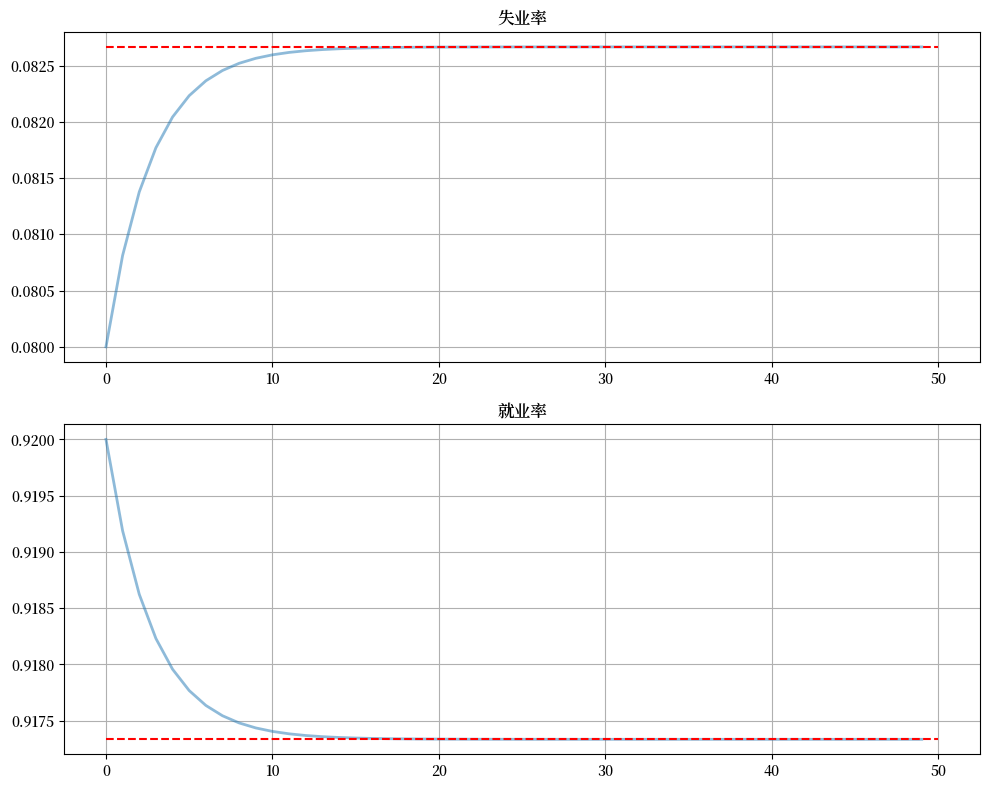

In [9]:
lm = LakeModel()
e_0 = 0.92     # 初始就业率
u_0 = 1 - e_0  # 初始失业率
T = 50         # 模拟长度

xbar = lm.rate_steady_state()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
x_0 = (u_0, e_0)
x_path = np.vstack(tuple(lm.simulate_rate_path(x_0, T)))

titles = ['失业率', '就业率']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i], lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()

(dynamics_workers)=
## 单个劳动者的动态

单个劳动者的就业动态由{doc}`有限状态马尔可夫过程 <finite_markov>`控制。

劳动者可以处于两种状态之一：

* $s_t=0$ 表示失业
* $s_t=1$ 表示就业

让我们首先假设 $b = d = 0$。

相关的转移矩阵为：

$$
P = \left(
        \begin{matrix}
            1 - \lambda & \lambda \\
            \alpha & 1 - \alpha
        \end{matrix}
    \right)
$$

令 $\psi_t$ 表示劳动者在t时刻就业/失业状态的{ref}`边际分布 <mc_md>`。

像往常一样，我们将其视为行向量。

我们从{ref}`之前的讨论 <mc_md>`中知道 $\psi_t$ 遵循运动规律：

$$
\psi_{t+1} = \psi_t P
$$

我们还从{doc}`有限马尔可夫链讲座 <finite_markov>`中知道，
如果 $\alpha \in (0, 1)$ 和 $\lambda \in (0, 1)$，则
$P$ 有唯一的平稳分布，这里记为 $\psi^*$。

唯一的平稳分布满足：

$$
\psi^*[0] = \frac{\alpha}{\alpha + \lambda}
$$

不足为奇，失业状态的概率质量随着
解雇率增加而增加，随着工作找到率增加而减少。

### 遍历性

让我们看看就业-失业周期的典型生命周期。

我们想要计算一个无限寿命的劳动者在就业和失业上花费的平均时间。

令：

$$
\bar s_{u,T} := \frac1{T} \sum_{t=1}^T \mathbb 1\{s_t = 0\}
$$

和

$$
\bar s_{e,T} := \frac1{T} \sum_{t=1}^T \mathbb 1\{s_t = 1\}
$$

（像往常一样，$\mathbb 1\{Q\} = 1$ 如果陈述 $Q$ 为真，否则为0）

这些是劳动者在T时期之前分别花费在失业和就业上的时间比例。

如果 $\alpha \in (0, 1)$ 和 $\lambda \in (0, 1)$，则 $P$ 是{ref}`遍历的 <ergodicity>`，因此我们有：

$$
\lim_{T \to \infty} \bar s_{u, T} = \psi^*[0]
\quad \text{和} \quad
\lim_{T \to \infty} \bar s_{e, T} = \psi^*[1]
$$

以概率1。

检查告诉我们，在假设 $b=d=0$ 下，$P$ 正好是 $\hat A$ 的转置。

因此，无限寿命劳动者花费在就业和失业上的时间百分比等于稳态分布中的就业和失业劳动者比例。

### 收敛率

时间序列样本平均值需要多长时间才能收敛到横截面平均值？

我们可以使用[QuantEcon.py](http://quantecon.org/quantecon-py)的
MarkovChain类来研究这个问题。

让我们绘制5000个时期的样本平均值路径

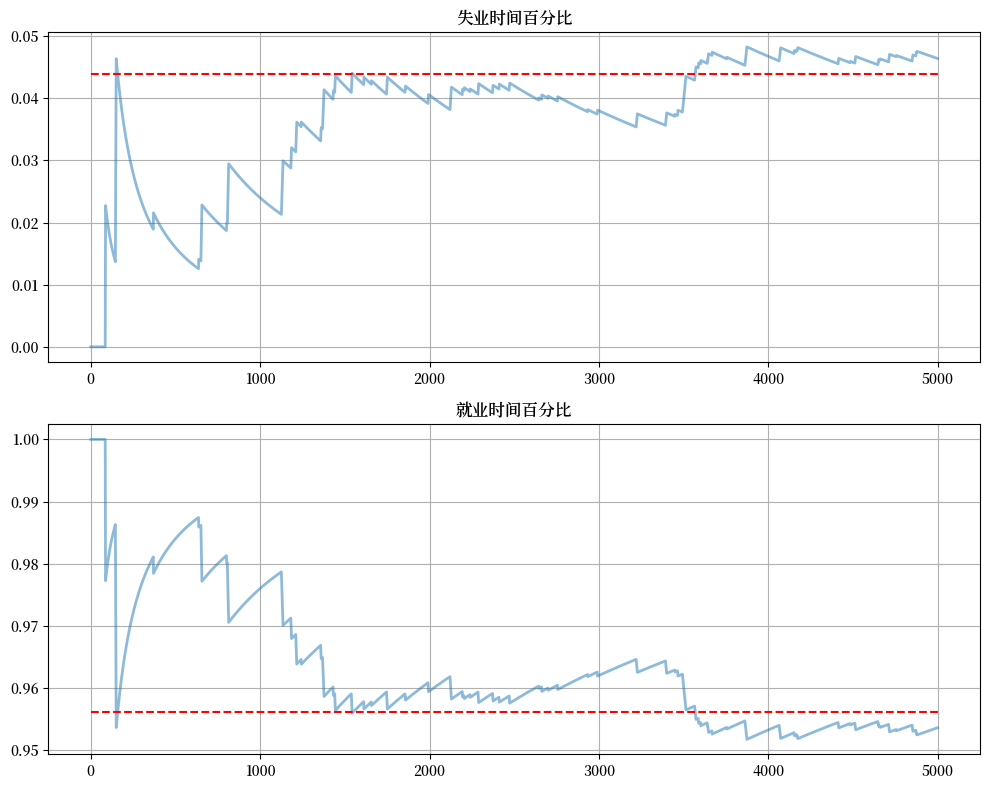

In [10]:
lm = LakeModel(d=0, b=0)
T = 5000  # 模拟长度

α, λ = lm.α, lm.λ

P = [[1 - λ,        λ],
    [    α,    1 - α]]

mc = MarkovChain(P)

xbar = lm.rate_steady_state()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
s_path = mc.simulate(T, init=1)
s_bar_e = s_path.cumsum() / range(1, T+1)
s_bar_u = 1 - s_bar_e

to_plot = [s_bar_u, s_bar_e]
titles = ['失业时间百分比', '就业时间百分比']

for i, plot in enumerate(to_plot):
    axes[i].plot(plot, lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(titles[i])
    axes[i].grid()

plt.tight_layout()
plt.show()

平稳概率由虚线红色给出。

在这种情况下，这两个对象需要很长时间才能收敛。

这主要是由于马尔可夫链的高持久性。

## 内生工作找到率

我们现在使雇佣率内生化。

从失业到就业的转换率将由McCall搜索模型{cite}`McCall1970`决定。

与以下讨论相关的所有细节都可以在{doc}`我们对该模型的讨论 <mccall_model>`中找到。

### 保留工资

关于这个模型要记住的最重要的事情是，最优决策
由保留工资 $\bar w$ 表征：

* 如果手中的工资报价 $w$ 大于或等于 $\bar w$，则劳动者接受。
* 否则，劳动者拒绝。

正如我们在{doc}`对模型的讨论 <mccall_model>`中看到的，保留工资取决于工资报价分布和参数：

* $\alpha$，分离率
* $\beta$，贴现因子
* $\gamma$，报价到达率
* $c$，失业补偿

### 将McCall搜索模型与湖泊模型联系起来

假设湖泊模型中的所有劳动者都按照McCall搜索模型行事。

离开就业的外生概率保持为 $\alpha$。

但他们的最优决策规则决定了离开失业的概率 $\lambda$。

现在这是：

```{math}
:label: lake_lamda

\lambda
= \gamma \mathbb P \{ w_t \geq \bar w\}
= \gamma \sum_{w' \geq \bar w} p(w')
```

### 财政政策

我们可以使用McCall搜索版本的湖泊模型来找到最优的失业保险水平。

我们假设政府设定失业补偿 $c$。

政府征收一次性税收 $\tau$ 以支付总失业金。

为了在稳态下实现预算平衡，税收、稳态失业率 $u$ 和失业补偿率必须满足：

$$
\tau = u c
$$

一次性税收适用于所有人，包括失业劳动者。

因此，工资为 $w$ 的就业劳动者的税后收入为 $w - \tau$。

失业劳动者的税后收入为 $c - \tau$。

对于每个政府政策规范 $(c, \tau)$，我们可以求解劳动者的最优保留工资。

这通过{eq}`lake_lamda` 在税后工资下确定 $\lambda$，这反过来又确定稳态失业率 $u(c, \tau)$。

对于给定的失业福利水平 $c$，我们可以求解在稳态下平衡预算的税收：

$$
\tau = u(c, \tau) c
$$

为了评估替代的政府税收-失业补偿对，我们需要一个福利标准。

我们使用稳态福利标准：

$$
W := e \,  {\mathbb E} [V \, | \,  \text{employed}] + u \,  U
$$

其中符号 $V$ 和 $U$ 如{doc}`McCall搜索模型讲座 <mccall_model>`中所定义。

工资报价分布将是对数正态分布 $LN(\log(20),1)$ 的离散化版本，如下图所示：

```{figure} /_static/lecture_specific/lake_model/lake_distribution_wages.png

```

我们将一个时期设为一个月。

我们将 $b$ 和 $d$ 设置为匹配美国人口的月度[出生](https://www.cdc.gov/nchs/fastats/births.htm)和[死亡](https://www.cdc.gov/nchs/fastats/deaths.htm)率：

* $b = 0.0124$
* $d = 0.00822$

根据{davis2006flow}`，我们将 $\alpha$（离开就业的风险率）设置为：

* $\alpha = 0.013$

### 财政政策代码

我们将使用来自{doc}`McCall模型讲座 <mccall_model>`的技术

第一段代码实现了价值函数迭代

In [11]:
# 默认效用函数

@jit
def u(c, σ):
    if c > 0:
        return (c**(1 - σ) - 1) / (1 - σ)
    else:
        return -10e6


class McCallModel:
    """
    存储与给定模型相关的参数和函数。
    """

    def __init__(self,
                α=0.2,       # 工作分离率
                β=0.98,      # 贴现率
                γ=0.7,       # 工作报价率
                c=6.0,       # 失业补偿
                σ=2.0,       # 效用参数
                w_vec=None,  # 可能的工资值
                p_vec=None): # w_vec上的概率

        self.α, self.β, self.γ, self.c = α, β, γ, c
        self.σ = σ

        # 使用beta-二项分布添加默认工资向量和概率
        if w_vec is None:
            n = 60  # 工资的可能结果数
            # 工资在10到20之间
            self.w_vec = np.linspace(10, 20, n)
            a, b = 600, 400  # 形状参数
            dist = BetaBinomial(n-1, a, b)
            self.p_vec = dist.pdf()
        else:
            self.w_vec = w_vec
            self.p_vec = p_vec

@jit
def _update_bellman(α, β, γ, c, σ, w_vec, p_vec, V, V_new, U):
    """
    更新贝尔曼方程的jitted函数。注意V_new是
    就地修改的（即由这个函数修改）。U的新值
    被返回。

    """
    for w_idx, w in enumerate(w_vec):
        # w_idx索引可能的工资向量
        V_new[w_idx] = u(w, σ) + β * ((1 - α) * V[w_idx] + α * U)

    U_new = u(c, σ) + β * (1 - γ) * U + \
                    β * γ * np.sum(np.maximum(U, V) * p_vec)

    return U_new


def solve_mccall_model(mcm, tol=1e-5, max_iter=2000):
    """
    迭代收敛到贝尔曼方程

    参数
    ----------
    mcm : McCallModel的实例
    tol : 浮点数
        误差容限
    max_iter : 整数
        最大迭代次数
    """

    V = np.ones(len(mcm.w_vec))  # V的初始猜测
    V_new = np.empty_like(V)     # 存储V的更新
    U = 1                        # U的初始猜测
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        U_new = _update_bellman(mcm.α, mcm.β, mcm.γ,
                mcm.c, mcm.σ, mcm.w_vec, mcm.p_vec, V, V_new, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1

    return V, U

第二段代码用于完成保留工资：

In [12]:
def compute_reservation_wage(mcm, return_values=False):
    """
    通过找到最小的w使得V(w) > U来计算McCall模型的保留工资。

    如果V(w) > U对所有w都成立，则保留工资w_bar被设置为
    mcm.w_vec中的最低工资。

    如果v(w) < U对所有w都成立，则w_bar被设置为np.inf。

    参数
    ----------
    mcm : McCallModel的实例
    return_values : 布尔值（可选，默认=False）
        也返回价值函数

    返回
    -------
    w_bar : 标量
        保留工资

    """

    V, U = solve_mccall_model(mcm)
    w_idx = np.searchsorted(V - U, 0)

    if w_idx == len(V):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vec[w_idx]

    if return_values == False:
        return w_bar
    else:
        return w_bar, V, U

现在让我们计算并绘制福利、就业、失业和税收收入作为
失业补偿率的函数

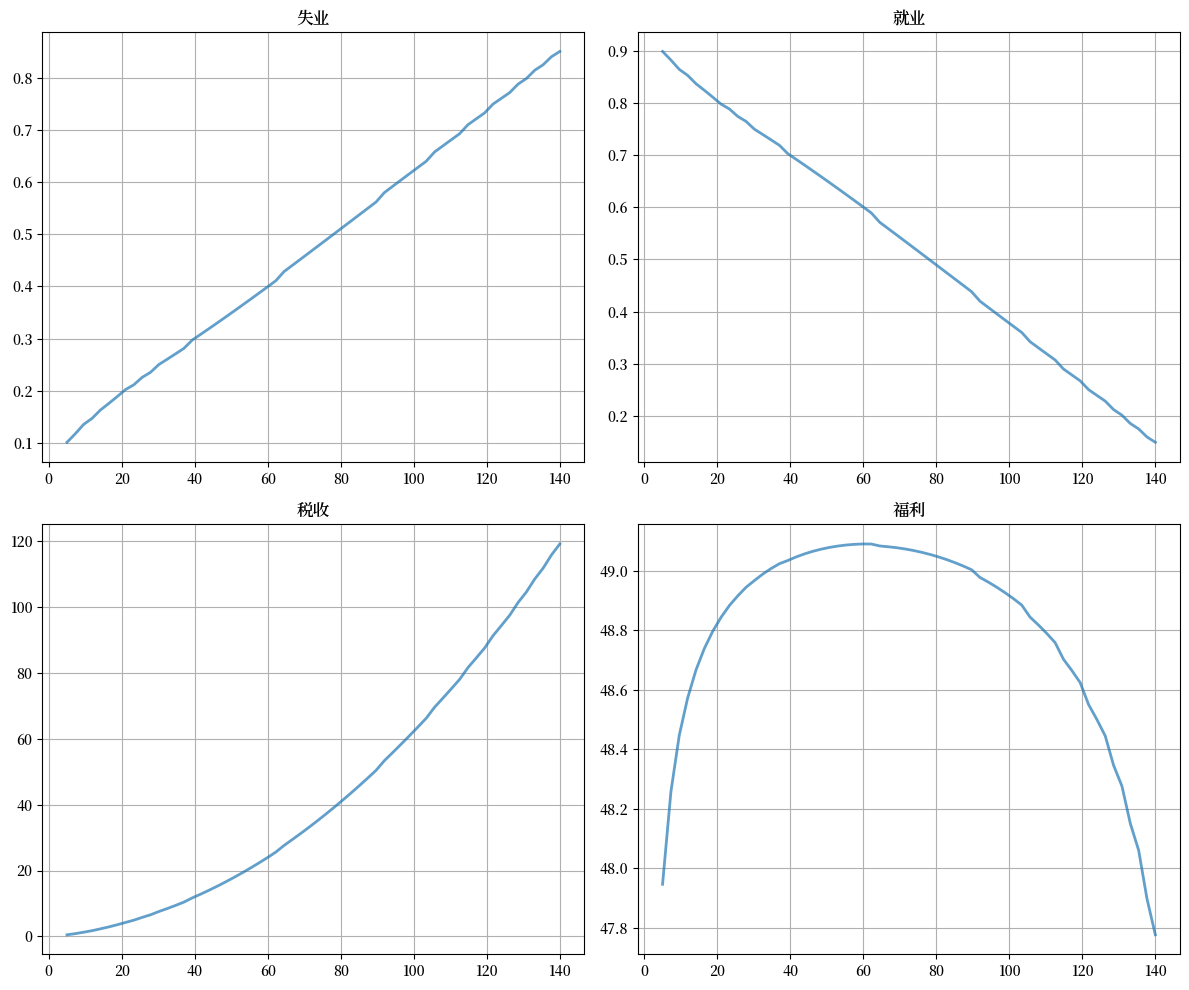

In [13]:
# 一些将保持不变的全局变量
α = 0.013
α_q = (1-(1-α)**3)   # 季度（α是月度）
b = 0.0124
d = 0.00822
β = 0.98
γ = 1.0
σ = 2.0

# 默认工资分布 --- 离散化的对数正态
log_wage_mean, wage_grid_size, max_wage = 20, 200, 170
logw_dist = norm(np.log(log_wage_mean), 1)
w_vec = np.linspace(1e-8, max_wage, wage_grid_size + 1)
cdf = logw_dist.cdf(np.log(w_vec))
pdf = cdf[1:] - cdf[:-1]
p_vec = pdf / pdf.sum()
w_vec = (w_vec[1:] + w_vec[:-1]) / 2


def compute_optimal_quantities(c, τ):
    """
    给定c和τ计算劳动者的保留工资、工作找到率和价值函数。

    """

    mcm = McCallModel(α=α_q,
                    β=β,
                    γ=γ,
                    c=c-τ,          # 税后补偿
                    σ=σ,
                    w_vec=w_vec-τ,  # 税后工资
                    p_vec=p_vec)

    w_bar, V, U = compute_reservation_wage(mcm, return_values=True)
    λ = γ * np.sum(p_vec[w_vec - τ > w_bar])
    return w_bar, λ, V, U

def compute_steady_state_quantities(c, τ):
    """
    使用McCall模型的最优数量计算给定c和τ的稳态失业率
    并计算相应的稳态数量

    """
    w_bar, λ, V, U = compute_optimal_quantities(c, τ)

    # 计算稳态就业和失业率
    lm = LakeModel(α=α_q, λ=λ, b=b, d=d)
    x = lm.rate_steady_state()
    u, e = x

    # 计算稳态福利
    w = np.sum(V * p_vec * (w_vec - τ > w_bar)) / np.sum(p_vec * (w_vec -
            τ > w_bar))
    welfare = e * w + u * U

    return e, u, welfare


def find_balanced_budget_tax(c):
    """
    找到将导致预算平衡的税收水平。

    """
    def steady_state_budget(t):
        e, u, w = compute_steady_state_quantities(c, t)
        return t - u * c

    τ = brentq(steady_state_budget, 0.0, 0.9 * c)
    return τ


# 我们想要研究的失业保险水平
c_vec = np.linspace(5, 140, 60)

tax_vec = []
unempl_vec = []
empl_vec = []
welfare_vec = []

for c in c_vec:
    t = find_balanced_budget_tax(c)
    e_rate, u_rate, welfare = compute_steady_state_quantities(c, t)
    tax_vec.append(t)
    unempl_vec.append(u_rate)
    empl_vec.append(e_rate)
    welfare_vec.append(welfare)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plots = [unempl_vec, empl_vec, tax_vec, welfare_vec]
titles = ['失业', '就业', '税收', '福利']

for ax, plot, title in zip(axes.flatten(), plots, titles):
    ax.plot(c_vec, plot, lw=2, alpha=0.7)
    ax.set_title(title)
    ax.grid()

plt.tight_layout()
plt.show()

福利首先增加然后随着失业福利的增加而减少。

使稳态福利最大化的水平约为62。

## 练习

```{exercise}
:label: lm_ex1

在湖泊模型中，有一些派生数据如 $A$，它依赖于原始参数如 $\alpha$
和 $\lambda$。

因此，当用户改变这些原始参数时，我们需要派生数据自动更新。

（例如，如果用户改变给定类实例的 $b$ 值，我们希望 $g = b - d$ 自动更新）

在上面的代码中，我们通过每次想要改变参数时创建新实例来解决这个问题。

这样派生数据总是与当前参数值匹配。

但是，我们可以使用描述符，这样当参数改变时派生数据就会更新。

这更安全，意味着我们不需要为每个新的参数化创建新实例。

（另一方面，代码变得更密集，这就是为什么我们在讲座中并不总是使用描述符方法。）

在这个练习中，您的任务是使用描述符和装饰器（如 `@property`）来安排 `LakeModel` 类。

（如果您需要刷新对这些如何工作的理解，请参阅[本讲座](https://python-programming.quantecon.org/python_advanced_features.html)。）
```

```{solution-start} lm_ex1
:class: dropdown
```

这是一个解决方案

In [14]:
class LakeModelModified:
    """
    求解湖泊模型并计算失业存量和比率的动态。

    参数:
    ------------
    λ : 标量
        当前失业劳动者的工作找到率
    α : 标量
        当前就业劳动者的解雇率
    b : 标量
        劳动力进入率
    d : 标量
        劳动力退出率

    """
    def __init__(self, λ=0.283, α=0.013, b=0.0124, d=0.00822):
        self._λ, self._α, self._b, self._d = λ, α, b, d
        self.compute_derived_values()

    def compute_derived_values(self):
        # 解包名称以简化表达式
        λ, α, b, d = self._λ, self._α, self._b, self._d

        self._g = b - d
        self._A = np.array([[(1-d) * (1-λ) + b,      (1 - d) * α + b],
                            [        (1-d) * λ,   (1 - d) * (1 - α)]])

        self._A_hat = self._A / (1 + self._g)

    @property
    def g(self):
        return self._g

    @property
    def A(self):
        return self._A

    @property
    def A_hat(self):
        return self._A_hat

    @property
    def λ(self):
        return self._λ

    @λ.setter
    def λ(self, new_value):
        self._λ = new_value
        self.compute_derived_values()

    @property
    def α(self):
        return self._α

    @α.setter
    def α(self, new_value):
        self._α = new_value
        self.compute_derived_values()

    @property
    def b(self):
        return self._b

    @b.setter
    def b(self, new_value):
        self._b = new_value
        self.compute_derived_values()

    @property
    def d(self):
        return self._d

    @d.setter
    def d(self, new_value):
        self._d = new_value
        self.compute_derived_values()


    def rate_steady_state(self, tol=1e-6):
        """
        找到系统 :math:`x_{t+1} = \hat A x_{t}` 的稳态

        返回
        --------
        xbar : 就业和失业率的稳态向量
        """
        x = np.array([self.A_hat[0, 1], self.A_hat[1, 0]])
        x /= x.sum()
        return x

    def simulate_stock_path(self, X0, T):
        """
        模拟就业和失业存量的序列

        参数
        ------------
        X0 : 数组
            包含初始值 (E0, U0)
        T : 整数
            模拟的时期数

        返回
        ---------
        X : 迭代器
            包含就业和失业存量的序列
        """

        X = np.atleast_1d(X0)  # 转换为数组以防万一
        for t in range(T):
            yield X
            X = self.A @ X

    def simulate_rate_path(self, x0, T):
        """
        模拟就业和失业率的序列

        参数
        ------------
        x0 : 数组
            包含初始值 (e0,u0)
        T : 整数
            模拟的时期数

        返回
        ---------
        x : 迭代器
            包含就业和失业率的序列

        """
        x = np.atleast_1d(x0)  # 转换为数组以防万一
        for t in range(T):
            yield x
            x = self.A_hat @ x

<>:81: SyntaxWarning: invalid escape sequence '\h'
<>:81: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_6682/324258217.py:81: SyntaxWarning: invalid escape sequence '\h'
  """


```{solution-end}
```

```{exercise-start}
:label: lm_ex2
```

考虑一个经济，初始劳动者存量 $N_0 = 100$ 处于
基准参数化下的稳态就业水平：

* $\alpha = 0.013$
* $\lambda = 0.283$
* $b = 0.0124$
* $d = 0.00822$

（$\alpha$ 和 $\lambda$ 的值遵循{davis2006flow}`）

假设为了应对新立法，雇佣率降低到 $\lambda = 0.2$。

绘制50个时期的失业和就业存量的转换动态。

绘制比率的转换动态。

经济需要多长时间才能收敛到新的稳态？

新的稳态就业水平是多少？

```{note}
使用练习1中创建的类可能更容易帮助改变变量。
```

```{exercise-end}
```


```{solution-start} lm_ex2
:class: dropdown
```

我们首先构建包含默认参数的类并将
稳态值分配给 `x0`

In [15]:
lm = LakeModelModified()
x0 = lm.rate_steady_state()
print(f"初始稳态: {x0}")

初始稳态: [0.08266627 0.91733373]


初始化模拟值

In [16]:
N0 = 100
T = 50

新立法将 $\lambda$ 改变为 $0.2$

In [17]:
lm.λ = 0.2

xbar = lm.rate_steady_state()  # 新稳态
X_path = np.vstack(tuple(lm.simulate_stock_path(x0 * N0, T)))
x_path = np.vstack(tuple(lm.simulate_rate_path(x0, T)))
print(f"新稳态: {xbar}")

新稳态: [0.11309295 0.88690705]


现在绘制存量

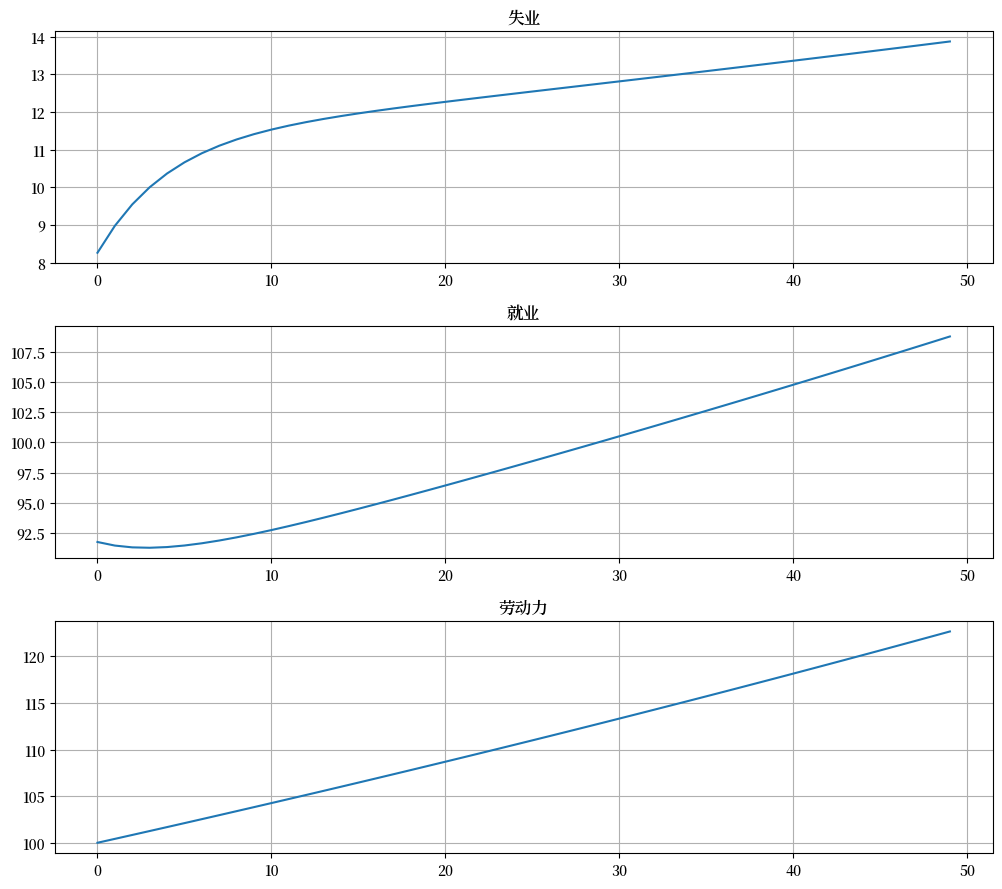

In [18]:
fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(X_path[:, 0])
axes[0].set_title('失业')

axes[1].plot(X_path[:, 1])
axes[1].set_title('就业')

axes[2].plot(X_path.sum(1))
axes[2].set_title('劳动力')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

以及比率如何演变

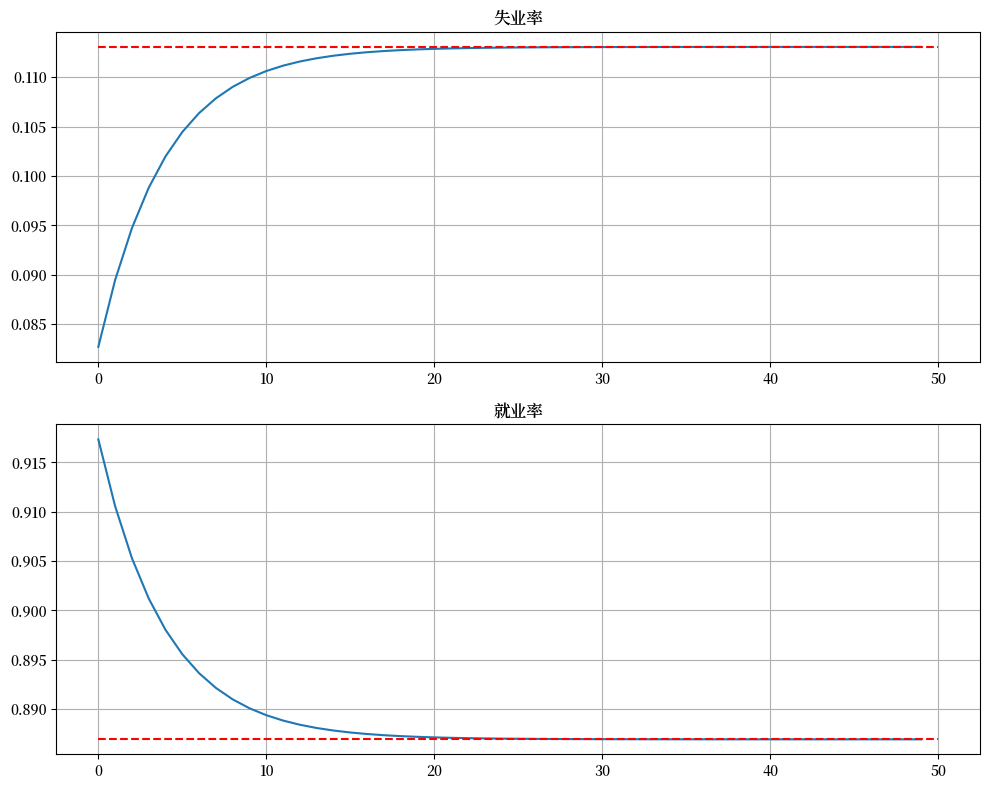

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

titles = ['失业率', '就业率']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()

我们看到经济需要20个时期才能收敛到新的
稳态水平。

```{solution-end}
```


```{exercise}
:label: lm_ex3

考虑一个经济，初始劳动者存量 $N_0 = 100$ 处于
基准参数化下的稳态就业水平。

假设出生率在20个时期内暂时较高（$b = 0.025$），然后恢复到原始水平。

绘制50个时期的失业和就业存量的转换动态。

绘制比率的转换动态。

经济需要多长时间才能恢复到原始稳态？
```

```{solution-start} lm_ex3
:class: dropdown
```

这个下一个练习让经济经历劳动力市场进入的繁荣，
然后恢复到原始水平。

在20个时期内，经济有新的劳动力进入率。

让我们从基准参数化开始并记录稳态

In [20]:
lm = LakeModelModified()
x0 = lm.rate_steady_state()

这是其他参数：

In [21]:
b_hat = 0.025
T_hat = 20

让我们将 $b$ 增加到新值并模拟20个时期

In [22]:
lm.b = b_hat
# 模拟存量
X_path1 = np.vstack(tuple(lm.simulate_stock_path(x0 * N0, T_hat)))
# 模拟比率
x_path1 = np.vstack(tuple(lm.simulate_rate_path(x0, T_hat)))

现在我们将 $b$ 重置为原始值，然后使用20个时期后的状态
作为新的初始条件，模拟额外的30个时期

In [23]:
lm.b = 0.0124
# 模拟存量
X_path2 = np.vstack(tuple(lm.simulate_stock_path(X_path1[-1, :2], T-T_hat+1)))
# 模拟比率
x_path2 = np.vstack(tuple(lm.simulate_rate_path(x_path1[-1, :2], T-T_hat+1)))

最后，我们将这两条路径组合并绘制

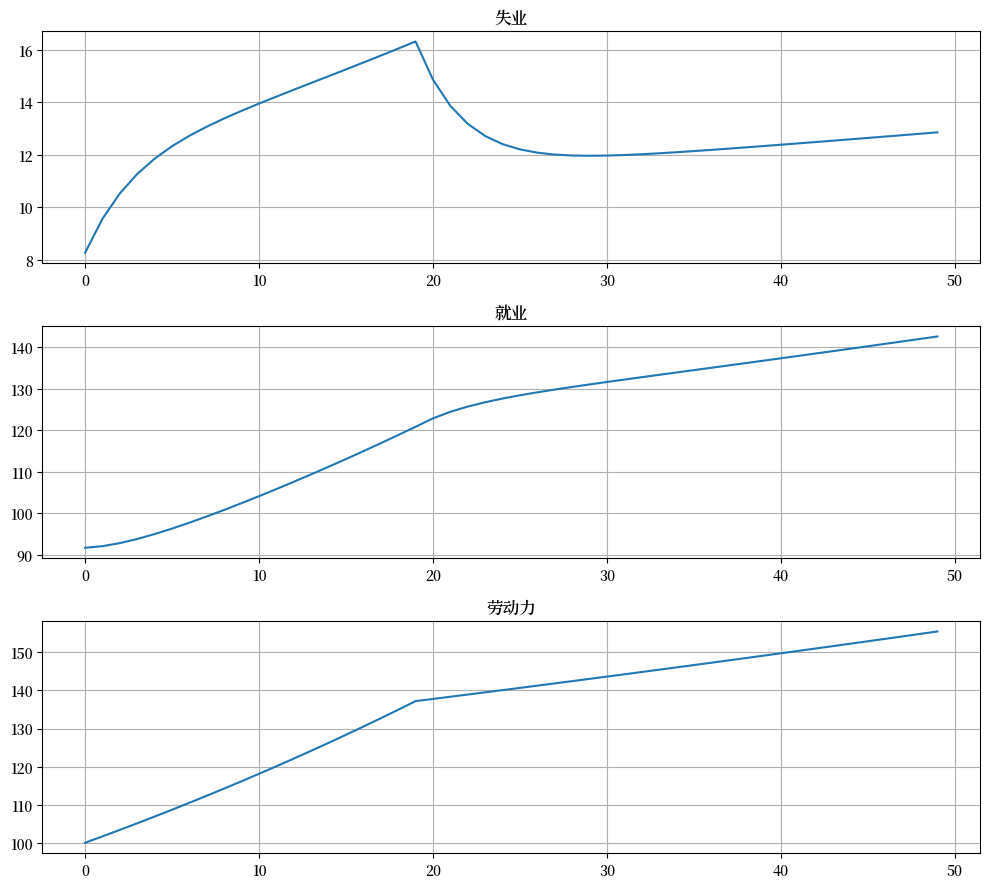

In [24]:
# 注意[1:]以避免重复第20期
x_path = np.vstack([x_path1, x_path2[1:]])
X_path = np.vstack([X_path1, X_path2[1:]])

fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(X_path[:, 0])
axes[0].set_title('失业')

axes[1].plot(X_path[:, 1])
axes[1].set_title('就业')

axes[2].plot(X_path.sum(1))
axes[2].set_title('劳动力')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

以及比率

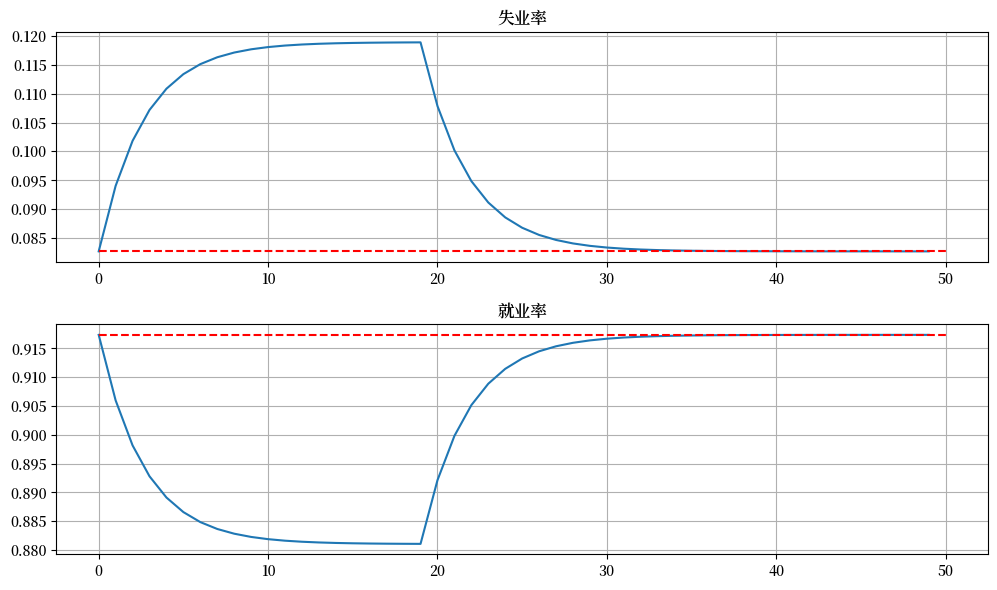

In [25]:
fig, axes = plt.subplots(2, 1, figsize=[10, 6])

titles = ['失业率', '就业率']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(x0[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()

```{solution-end}
```